In [23]:
# Jannik's models are not SAE Lens, so use Baukit
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
# tiny model is in a different direction, add current one to path
import sys
from pathlib import Path
# Get the parent directory of current_dir
parent_dir = str(Path("/root/GroupedSAEs/notebooks/tiny_circuits.ipynb").parent.parent)
sys.path.append(parent_dir)
# from tiny_model.tiny_model import TinyModel, tokenizer
from tiny_model import TinyModel, tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyModel().to(device)

In [24]:
from datasets import load_dataset, Dataset
from tqdm import tqdm
def download_dataset(dataset_name, tokenizer, max_length=256, num_datapoints=None):
    if(num_datapoints):
        split_text = f"train[:{num_datapoints}]"
    else:
        split_text = "train"
    dataset = load_dataset(dataset_name, split=split_text)
    print(dataset)
    total_failed_tokens = 0
    all_tokens = []
    for text in tqdm(dataset["text"]):
        try:
            tokens = [9996] + tokenizer.encode(text)[:max_length]
        except:
            total_failed_tokens += 1
            continue
        # only include if it's at least max_length
        if len(tokens) == max_length+1:
            all_tokens.append(tokens)
    print(f"Failed to tokenize {total_failed_tokens} tokens")
    # convert into a dataset class
    return  Dataset.from_dict({"input_ids": all_tokens})


dataset_name = "noanabeshima/TinyStoriesV2"
max_seq_length = 50
num_datapoints = 1000
# max_seq_length = 100
# num_datapoints = 500
print(f"Downloading {dataset_name}")
dataset = download_dataset(dataset_name, tokenizer=tokenizer, max_length=max_seq_length, num_datapoints=num_datapoints)
true_num_datapoints = len(dataset)
# added BOS
max_seq_length +=1
total_tokens = max_seq_length * true_num_datapoints
print(f"Number of datapoints w/ {max_seq_length} tokens: {true_num_datapoints}")
print(f"Total Tokens: {total_tokens / 1e6}M")

Dataset({
    features: ['text'],
    num_rows: 1000
})


100%|██████████| 1000/1000 [00:02<00:00, 471.08it/s]


Failed to tokenize 0 tokens
Number of datapoints w/ 51 tokens: 1000
Total Tokens: 0.051M


In [2]:
from huggingface_hub import hf_hub_download
from tiny_model import parse_mlp_tag, SparseMLP

# import torch
model_id = "Elriggs/pythia-70m-deduped-layer-2"
# all_autoencoders = torch.load(ae_download_location)
repo_id = "noanabeshima/tiny_model"
seed=0
layer=0
layer +=1
filename = f"res_pre_mlp/Rm{seed}_S-{layer}_R1_P0.pt"
sae_download_location = hf_hub_download(repo_id=repo_id, filename=filename)
state_dict = torch.load(sae_download_location)
n_features, d_model = state_dict["encoder.weight"].shape
mlp = SparseMLP(d_model=d_model, n_features=n_features)
mlp.load_state_dict(state_dict)

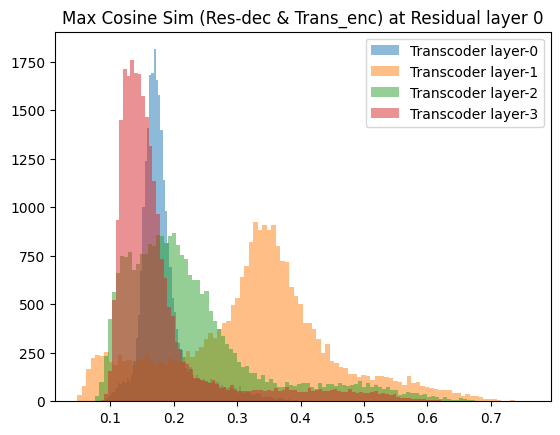

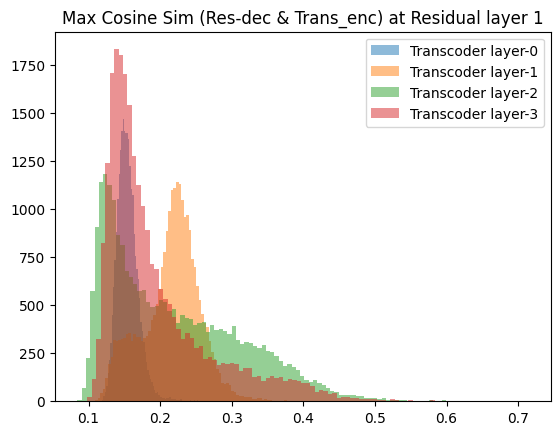

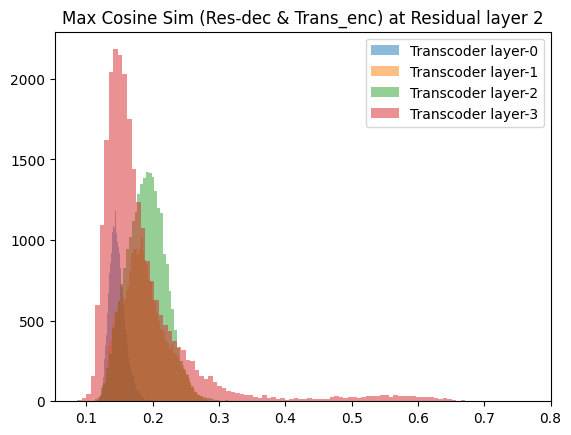

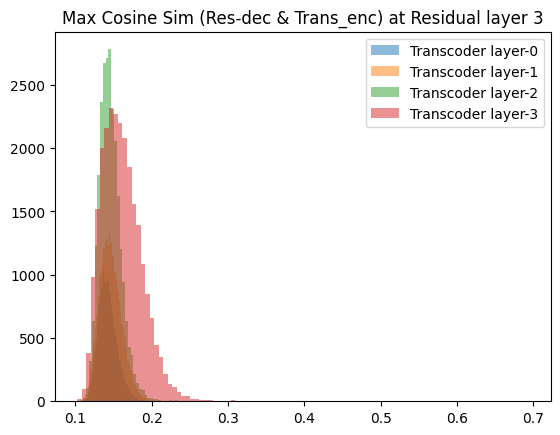

In [51]:
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# First, check all seeds
def get_dec_enc_cos_sim(sae1, sae2):
    sae1_decoder = sae1.decoder.weight.data
    sae2_encoder = sae2.encoder.weight.data
    sae1_decoder = sae1_decoder / sae1_decoder.norm(dim=0, keepdim=True)
    sae2_encoder = sae2_encoder / sae2_encoder.norm(dim=1, keepdim=True)
    sae1_decoder.shape, sae2_encoder.shape
    cos_sim = sae1_decoder.T @ sae2_encoder.T
    return cos_sim


max_layers = 4
max_l1_vals = 6
for layer in range(max_layers):
    # new figure
    plt.figure()
    file, _, _, _ = parse_mlp_tag(f"T{layer}")
    transcoder = SparseMLP.from_pretrained(file).to(device)

    # for l1_val in range(1, max_l1_vals):
    for inner_layer in range(max_layers):
        # filename = f"res_pre_mlp/Rm{layer+1}_S-{l1_val}_R1_P0.pt"
        filename = f"res_pre_mlp/Rm{inner_layer}_S-{3}_R1_P0.pt"
        sae_download_location = hf_hub_download(repo_id=repo_id, filename=filename)
        state_dict = torch.load(sae_download_location)
        n_features, d_model = state_dict["encoder.weight"].shape
        res = SparseMLP(d_model=d_model, n_features=n_features)
        res.load_state_dict(state_dict)
        res.to(device)

        cos_sim = get_dec_enc_cos_sim(transcoder, res)
        max_cos_sim = cos_sim.max(dim=0).values.cpu().numpy()

        # make new hist
        plt.hist(max_cos_sim, bins=100, alpha=0.5, label=f"Transcoder layer-{inner_layer}")
    plt.title(f"Max Cosine Sim (Res-dec & Trans_enc) at Residual layer {layer}")
    plt.legend()
    plt.show()

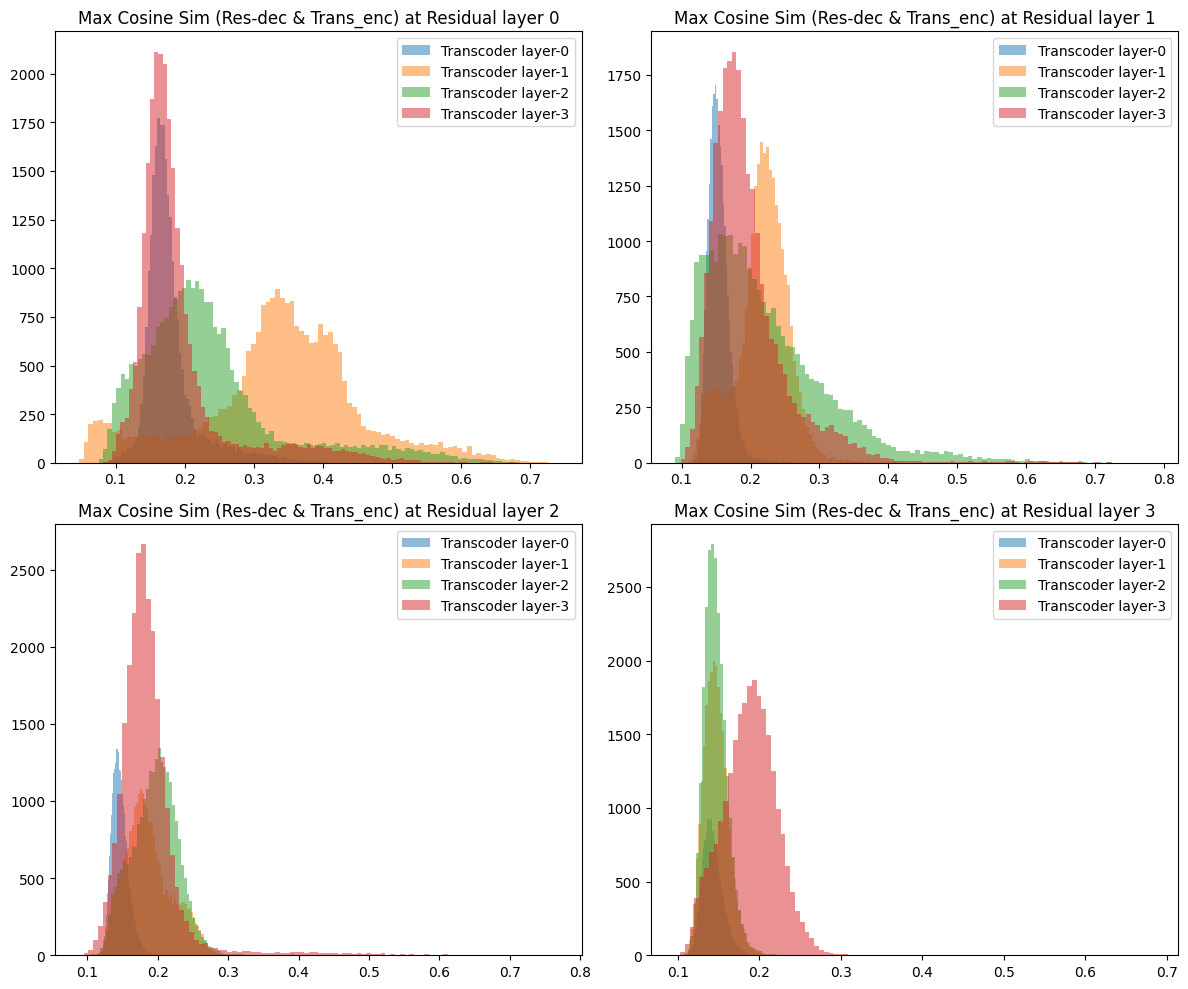

In [53]:
import matplotlib.pyplot as plt

max_layers = 4
max_l1_vals = 6
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for layer in range(max_layers):
    row = layer // 2
    col = layer % 2
    ax = axs[row, col]
    file, _, _, _ = parse_mlp_tag(f"T{layer}")
    transcoder = SparseMLP.from_pretrained(file).to(device)

    for inner_layer in range(max_layers):
        filename = f"res_pre_mlp/Rm{inner_layer}_S-{5}_R1_P0.pt"
        sae_download_location = hf_hub_download(repo_id=repo_id, filename=filename)
        state_dict = torch.load(sae_download_location)
        n_features, d_model = state_dict["encoder.weight"].shape
        res = SparseMLP(d_model=d_model, n_features=n_features)
        res.load_state_dict(state_dict)
        res.to(device)

        cos_sim = get_dec_enc_cos_sim(transcoder, res)
        max_cos_sim = cos_sim.max(dim=0).values.cpu().numpy()

        ax.hist(max_cos_sim, bins=100, alpha=0.5, label=f"Transcoder layer-{inner_layer}")
    
    ax.set_title(f"Max Cosine Sim (Res-dec & Trans_enc) at Residual layer {layer}")
    ax.legend()

fig.tight_layout()
plt.show()


In [27]:
len(model.torso)

4

In [ ]:
# Now let's check L0, MSE, and Cos-sim (between x & x_hat)
#set torch grad to zero globally
from torch.utils.data import DataLoader
from einops import rearrange
from tqdm import tqdm

batch_size = 128
# def get_dictionary_activations(model, dataset, cache_name, max_seq_length, autoencoder, batch_size=32):
L0s = [[[] for _ in range(max_layers)] for _ in range(max_l1_vals)]
MSEs = [[[] for _ in range(max_layers)] for _ in range(max_l1_vals)]
CosSims = [[[] for _ in range(max_layers)] for _ in range(max_l1_vals)]

with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for batch_ind, batch in enumerate(tqdm(dl)):
        batch = batch.to(model.device)
        token_list[batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = rearrange(batch, "b s -> (b s)")
        for sae_ind, sae in enumerate([sae_res, skip_sae]):
            feature_acts = model[activation_names[sae_ind]](batch)
            feature_acts[:, :skip_first_n_pos] = 0
            feature_acts = rearrange(feature_acts, "b s n -> (b s) n" )

            all_dictionary_activations[sae_ind][batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = feature_acts.cpu()
            if sae_ind==0:
                reconstruction_residual = sae.decoder(feature_acts)
                first_feature_mask = (feature_acts !=0).float()
                residual_correlation += torch.mm(first_feature_mask.T, first_feature_mask).int().cpu()
            else:
                second_feature_mask = (feature_acts !=0).float()
                skip_correlation += torch.mm(second_feature_mask.T, second_feature_mask).int().cpu()

                # Calculate the correlation between the residual and skip activations
                residual_and_skip_correlation += torch.mm(first_feature_mask.T, second_feature_mask).int().cpu()


                # Check the MSE between the skip features & skip-features-w/-residual
                skip_feature_x_hat = skip_sae.encoder(reconstruction_residual)
                skip_feature_mse = torch.mean((skip_feature_x_hat - feature_acts)**2, dim=-1)
                feature_act_var = torch.var(feature_acts)
                skip_feature_var_explained = 1 - skip_feature_mse / feature_act_var
                feature_mse[batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = skip_feature_mse.cpu()
                feature_var_explained[batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = skip_feature_var_explained.cpu()